* **요약**은 입력과 출력이 텍스트인, 고전적인 시퀀스-투-시퀀스 seq2seq 작업
  * 인코더-디코더 트랜스포머가 잘 맞음

# **0. Library**

In [ ]:
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=6)
# Base ; ["transformers", "datasets", "accelerate", "sentencepiece", "sacrebleu", "rouge-score", "nltk", "py7zr"],
# Ch 6 ; 
  # nltk==3.6.6 ; Natural Language Toolkit
  # sacrebleu==1.5.1
  # rouge-score==0.0.4
  # py7zr # Needed for samsum dataset

Cloning into 'nlp-with-transformers'...
remote: Enumerating objects: 588, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 588 (delta 5), reused 3 (delta 1), pack-reused 569
Receiving objects: 100% (588/588), 57.41 MiB | 35.27 MiB/s, done.
Resolving deltas: 100% (293/293), done.
/content/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.27.1
Using datasets v2.10.1
Using accelerate v0.17.1
Using sentencepiece v0.1.97
Using sacrebleu v2.3.1
Using rouge_score
Using nltk v3.8.1
Using py7zr v0.20.4


In [ ]:
from transformers import pipeline, set_seed

# **1. Dataset**

In [ ]:
from datasets import load_dataset

# "cnn_dailymail" 데이터셋 다운로드 에러가 발생할 경우 대신 "ccdv/cnn_dailymail"을 사용하세요.
dataset = load_dataset("cnn_dailymail", version="3.0.0") 

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset cnn_dailymail downloaded and prepared to /root/.cache/huggingface/datasets/cnn_dailymail/default/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

**CNN/DailyMail** 
* 300,000개 뉴스 기사와 요약의 쌍으로 구성
* 요약은 본문에서 추출되지 않고 추상적
* 3.0.0 버전은 익명화 처리 X

In [ ]:
sample = dataset["train"][1]
sample

{'article': 'Editor\'s note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O\'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most severe mental illnesses are incarcerated until they\'re ready to appear in court. Most often, they face drug charges or charges of assaulting an officer --charges that Judge Steven Leifman says are usually "avoidable felonies." He says the arrests often result from confrontations with police. Mentally ill people often won\'t do what they\'re told when police arrive on the scene -- confrontation seems to exacerbate their illness and they become more paranoid, delusional, and less li

In [ ]:
print(sample['article'])

Editor's note: In our Behind the Scenes series, CNN correspondents share their
experiences in covering news and analyze the stories behind the events. Here,
Soledad O'Brien takes users inside a jail where many of the inmates are mentally
ill. An inmate housed on the "forgotten floor," where many mentally ill inmates
are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the
Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here,
inmates with the most severe mental illnesses are incarcerated until they're
ready to appear in court. Most often, they face drug charges or charges of
assaulting an officer --charges that Judge Steven Leifman says are usually
"avoidable felonies." He says the arrests often result from confrontations with
police. Mentally ill people often won't do what they're told when police arrive
on the scene -- confrontation seems to exacerbate their illness and they become
more paranoid, delusional, and less likely to follow dir

In [ ]:
print(f"특성: {dataset['train'].column_names}")

특성: ['article', 'highlights', 'id']


In [ ]:
print(f"""기사 (500개 문자 발췌, 총 길이: {len(sample["article"])}):""")
print(sample["article"][:500])
print(f'\n요약 (길이: {len(sample["highlights"])}):')
print(sample["highlights"])

기사 (500개 문자 발췌, 총 길이: 4051):
Editor's note: In our Behind the Scenes series, CNN correspondents share their
experiences in covering news and analyze the stories behind the events. Here,
Soledad O'Brien takes users inside a jail where many of the inmates are mentally
ill. An inmate housed on the "forgotten floor," where many mentally ill inmates
are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the
Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here,
inmates with the most s

요약 (길이: 281):
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .


Mentally ill inmates in Miami are housed on the "forgotten floor"

마이애미에서 정신 질환자 수감자들이 '잊혀진 층'에서 수용되고 있습니다. 


---


Judge Steven Leifman says most are there as a result of "avoidable felonies"

스티븐 라이프먼 판사는 그들 대부분이 "예방 가능한 중죄"로 이곳에 수감되어 있다고 말합니다.


---


While CNN tours facility, patient shouts: "I am the son of the president"

CNN이 시설을 견학하는 동안 한 환자는 "나는 대통령의 아들이다"라고 외쳤습니다.


---


Leifman says the system is unjust and he's fighting for change .

라이프먼 판사는 시스템이 불공평하며 변화를 위해 싸우고 있다고 말합니다.

# **2. Pipeline**
* 요약에서는 관례적으로 요약 문장을 줄바꿈으로 나눔


In [ ]:
sample_text = dataset["train"][1]["article"][:2000] # 위 Sample의 article 2000문자까지지
print(f'sample_text의 길이 : {len(sample_text)}')
sample_text

sample_text의 길이 : 2000


'Editor\'s note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O\'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most severe mental illnesses are incarcerated until they\'re ready to appear in court. Most often, they face drug charges or charges of assaulting an officer --charges that Judge Steven Leifman says are usually "avoidable felonies." He says the arrests often result from confrontations with police. Mentally ill people often won\'t do what they\'re told when police arrive on the scene -- confrontation seems to exacerbate their illness and they become more paranoid, delusional, and less likely to foll

In [ ]:
summaries = {}

## 2.1. nltk sent_tokenize

- 문장 토큰화, 토큰의 단위를 문장으로 하여 코퍼스 내 텍스트를 문장 단위로 구분하는 작업

In [ ]:
import nltk
from nltk.tokenize import sent_tokenize # 구두점, 약어 등을 구별하는 정교한 알고리즘 있음

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
string = "The U.S. are a country. The U.N. is an organization."
sent_tokenize(string) # 문장 나눠 요약해줌

['The U.S. are a country.', 'The U.N. is an organization.']

In [ ]:
def three_sentence_summary(text): # 맨 처음 문장 세 개
    return "\n".join(sent_tokenize(text)[:3])

In [ ]:
summaries["baseline"] = three_sentence_summary(sample_text)

In [ ]:
summaries

{'baseline': 'Editor\'s note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.\nHere, Soledad O\'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.\nMIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."'}

In [ ]:
print(summaries['baseline'])

Editor's note: In our Behind the Scenes series, CNN correspondents share their
experiences in covering news and analyze the stories behind the events.
Here, Soledad O'Brien takes users inside a jail where many of the inmates are
mentally ill. An inmate housed on the "forgotten floor," where many mentally ill
inmates are housed in Miami before trial.
MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention
facility is dubbed the "forgotten floor."


In [ ]:
print(sample['highlights'])

Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .


## 2.2. GPT-2
* 입력 텍스트 뒤에 'TL;DR'을 추가해 요약을 생성
* TL;DR : too long; didn't read

In [ ]:
from transformers import pipeline, set_seed

set_seed(42)

In [ ]:
pipe = pipeline("text-generation", model="gpt2-xl") # gpt2-xl 메모리 주의 -> gpt or gpt2-large

In [ ]:
gpt2_query = sample_text + "\nTL;DR:\n"
print(gpt2_query)

Editor's note: In our Behind the Scenes series, CNN correspondents share their
experiences in covering news and analyze the stories behind the events. Here,
Soledad O'Brien takes users inside a jail where many of the inmates are mentally
ill. An inmate housed on the "forgotten floor," where many mentally ill inmates
are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the
Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here,
inmates with the most severe mental illnesses are incarcerated until they're
ready to appear in court. Most often, they face drug charges or charges of
assaulting an officer --charges that Judge Steven Leifman says are usually
"avoidable felonies." He says the arrests often result from confrontations with
police. Mentally ill people often won't do what they're told when police arrive
on the scene -- confrontation seems to exacerbate their illness and they become
more paranoid, delusional, and less likely to follow dir

In [ ]:
pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)
pipe_out

/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1201: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


[{'generated_text': 'Editor\'s note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O\'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most severe mental illnesses are incarcerated until they\'re ready to appear in court. Most often, they face drug charges or charges of assaulting an officer --charges that Judge Steven Leifman says are usually "avoidable felonies." He says the arrests often result from confrontations with police. Mentally ill people often won\'t do what they\'re told when police arrive on the scene -- confrontation seems to exacerbate their illness and they become more paranoid, delusional, and

In [ ]:
print(pipe_out[0]['generated_text'])

Editor's note: In our Behind the Scenes series, CNN correspondents share their
experiences in covering news and analyze the stories behind the events. Here,
Soledad O'Brien takes users inside a jail where many of the inmates are mentally
ill. An inmate housed on the "forgotten floor," where many mentally ill inmates
are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the
Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here,
inmates with the most severe mental illnesses are incarcerated until they're
ready to appear in court. Most often, they face drug charges or charges of
assaulting an officer --charges that Judge Steven Leifman says are usually
"avoidable felonies." He says the arrests often result from confrontations with
police. Mentally ill people often won't do what they're told when police arrive
on the scene -- confrontation seems to exacerbate their illness and they become
more paranoid, delusional, and less likely to follow dir

In [ ]:
summaries["gpt2"] = "\n".join(
    sent_tokenize(pipe_out[0]["generated_text"][len(gpt2_query) :]))
summaries

{'baseline': 'Editor\'s note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.\nHere, Soledad O\'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.\nMIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."',
 'gpt2': '- No shoes.\n- No bed.\n- No mattress.\n- Some inmates sleeping on the floor.\n- Lacks security.\n- Insufficient funds to provide mental health care.'}

## 2.3. T5
* T5는 요약을 포함한 여러 작업에서 마스킹된 단어를 재구성하기 위한 비지도 학습 데이터와 지도 학습 데이터를 섞은 데이터로 훈련됨
  * 따라서 미세 튜닝 없이 이 체크포인트를 사전 훈련에 썼던 것과 동일한 프롬프트를 사용해 바로 요약에 사용 가능
  

In [ ]:
pipe = pipeline("summarization", model="t5-large")

/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [ ]:
pipe_out = pipe(sample_text)
print(pipe_out)

/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1201: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


[{'summary_text': 'mentally ill inmates are housed on the ninth floor of a
florida jail . most face drug charges or charges of assaulting an officer .
judge says arrests often result from confrontations with police . one-third of
all people in Miami-dade county jails are mental ill .'}]


In [ ]:
summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))
summaries

{'baseline': 'Editor\'s note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.\nHere, Soledad O\'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.\nMIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."',
 'gpt2': '- No shoes.\n- No bed.\n- No mattress.\n- Some inmates sleeping on the floor.\n- Lacks security.\n- Insufficient funds to provide mental health care.',
 't5': 'mentally ill inmates are housed on the ninth floor of a florida jail .\nmost face drug charges or charges of assaulting an officer .\njudge says arrests often result from confrontations with police .\none-third of all people in Miami-dade county jails are mental ill .'}

## 2.4. BART
* 인코더-디코더를 사용하는 모델, 손상된 입력을 재구성하도록 훈련
*  BERT와 GPT-2의 사전 훈련 방식 결합 

In [ ]:
pipe = pipeline("summarization", model="facebook/bart-large-cnn") # facebook/bart-large-cnn ; CNN/DailyMail 데이터셋에 미세 튜닝됨

In [ ]:
pipe_out = pipe(sample_text)
print(pipe_out)

[{'summary_text': 'Mentally ill inmates are housed on the "forgotten floor" of
Miami-Dade jail. Most often, they face drug charges or charges of assaulting an
officer. Judge Steven Leifman says the arrests often result from confrontations
with police. He says about one-third of all people in the county jails are
mentally ill.'}]


In [ ]:
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))
summaries

{'baseline': 'Editor\'s note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.\nHere, Soledad O\'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.\nMIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."',
 'gpt2': '- No shoes.\n- No bed.\n- No mattress.\n- Some inmates sleeping on the floor.\n- Lacks security.\n- Insufficient funds to provide mental health care.',
 't5': 'mentally ill inmates are housed on the ninth floor of a florida jail .\nmost face drug charges or charges of assaulting an officer .\njudge says arrests often result from confrontations with police .\none-third of all people in Miami-dade county jails are mental ill .',
 'bart': 'Mentally ill inmates are housed on the "forgotten floor" o

## 2.5. PEGASUS
* 인코더-디코더 트랜스포머 
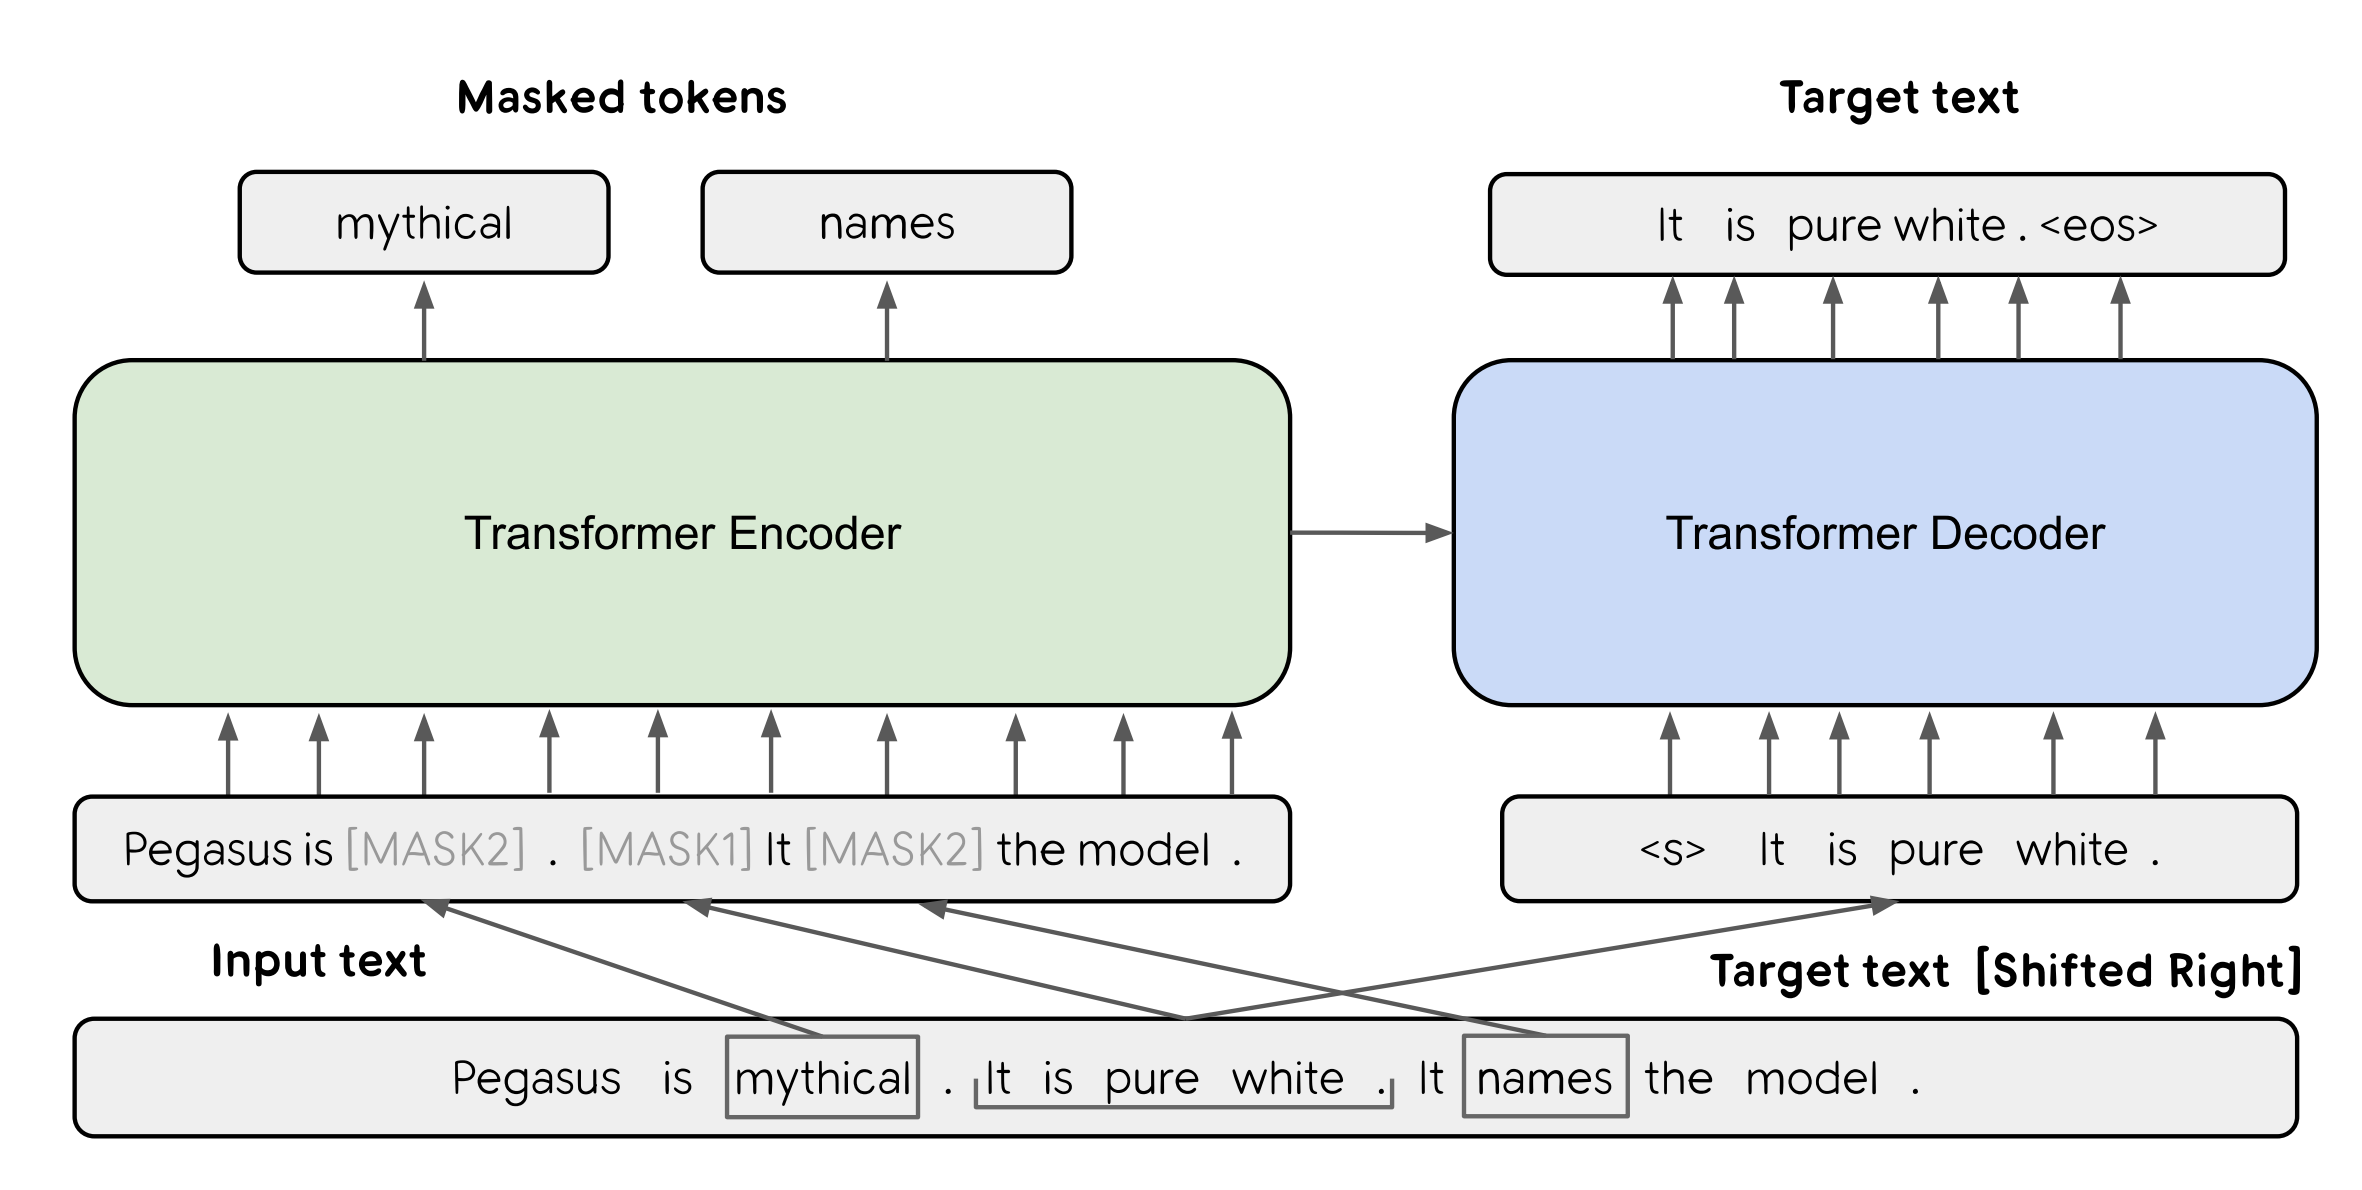

* 여러 문장으로 구성된 텍스트에서 마스킹된 문장을 예측하는 사전 훈련 목표로 훈련됐음

In [ ]:
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")

In [ ]:
pipe_out = pipe(sample_text)
print(pipe_out)

[{'summary_text': 'Mentally ill inmates in Miami are housed on the "forgotten
floor"<n>The ninth floor is where they\'re held until they\'re ready to appear
in court .<n>Most often, they face drug charges or charges of assaulting an
officer .<n>They end up on the ninth floor severely mentally disturbed .'}]


In [ ]:
summaries["pegasus"] = pipe_out[0]["summary_text"].replace(" .<n>", ".\n")
summaries

{'baseline': 'Editor\'s note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.\nHere, Soledad O\'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.\nMIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."',
 'gpt2': '- No shoes.\n- No bed.\n- No mattress.\n- Some inmates sleeping on the floor.\n- Lacks security.\n- Insufficient funds to provide mental health care.',
 't5': 'mentally ill inmates are housed on the ninth floor of a florida jail .\nmost face drug charges or charges of assaulting an officer .\njudge says arrests often result from confrontations with police .\none-third of all people in Miami-dade county jails are mental ill .',
 'bart': 'Mentally ill inmates are housed on the "forgotten floor" o

# **3. 요약 결과 비교 및 평가**
* GPT-2 : 데이터셋에서 전혀 훈련되지 않음
* T5 : 여러 작업 중의 하나인 이 작업을 위해 미세 튜닝됨
* BART, PEGASUS : 이 작업만을 위해 미세 튜닝됨 

In [ ]:
print("GROUND TRUTH")
print(dataset["train"][1]["highlights"]) # 실제 요약본
print("")

for model_name in summaries:
    print(model_name.upper())
    print(summaries[model_name])
    print("")

GROUND TRUTH
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .

BASELINE
Editor's note: In our Behind the Scenes series, CNN correspondents share their
experiences in covering news and analyze the stories behind the events.
Here, Soledad O'Brien takes users inside a jail where many of the inmates are
mentally ill. An inmate housed on the "forgotten floor," where many mentally ill
inmates are housed in Miami before trial.
MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention
facility is dubbed the "forgotten floor."

GPT2
- No shoes.
- No bed.
- No mattress.
- Some inmates sleeping on the floor.
- Lacks security.
- Insufficient funds to provide mental health care.

T5
mentally ill inmates are housed on the ninth floor of a florida jail 

* **GPT-2**
  * 진짜 요약을 하도록 명시적으로 훈련되지 않음
  * 종종 사실을 지어내거나, 환상을 만들어냄
* **PEGASUS, T5, BART**
  * 비슷함
  * 책에서는 PEGASUS 출력이 정답 출력과 가장 비슷하다고 하는데, 데이터가 달라서 그런듯

* 텍스트 생성에 좋은 모델을 판별하기
  * 여태 사용한 정확도, 정밀도, 재현율 같은 건 적합하지 않음
  * 정답 요약에서 동의어를 쓰거나 조금씩 바꾸거나 해서 수십 개의 요약이 나올 수 있기 때문

## 3.1. BLEU
* 생성된 텍스트에서 얼마나 많은 토큰이 참조 텍스트 토큰과 완벽하게 정렬됐는지 확인, 단어 또는 n-그램을 체크
* 정밀도를 근간으로 하는 지표
* 두 텍스트를 비교할 때, 참조 텍스트에 있는 단어가 생성된 단어 텍스트에 얼마나 자주 등장하는지 카운트, 그 후 생성된 텍스트 길이로 나눔

In [ ]:
from datasets import load_metric

bleu_metric = load_metric("sacrebleu")

<ipython-input-57-eacc06f6d0e4>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric("sacrebleu")


In [ ]:
# Example

import pandas as pd
import numpy as np

bleu_metric.add(
    prediction="the the the the the the", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,0.0
counts,"[2, 0, 0, 0]"
totals,"[6, 5, 4, 3]"
precisions,"[33.33, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,6
ref_len,6


In [ ]:
bleu_metric.add(
    prediction="the cat is on mat", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,57.893007
counts,"[5, 3, 2, 1]"
totals,"[5, 4, 3, 2]"
precisions,"[100.0, 75.0, 66.67, 50.0]"
bp,0.818731
sys_len,5
ref_len,6


## 3.2. ROUGE

In [ ]:
rouge_metric = load_metric("rouge")

In [ ]:
reference = dataset["train"][1]["highlights"]
records = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

In [ ]:
reference

'Mentally ill inmates in Miami are housed on the "forgotten floor"\nJudge Steven Leifman says most are there as a result of "avoidable felonies"\nWhile CNN tours facility, patient shouts: "I am the son of the president"\nLeifman says the system is unjust and he\'s fighting for change .'

In [ ]:
for model_name in summaries:
    rouge_metric.add(prediction=summaries[model_name], reference=reference)
    score = rouge_metric.compute()
    rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
    records.append(rouge_dict)
pd.DataFrame.from_records(records, index=summaries.keys())

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.365079,0.145161,0.206349,0.285714
gpt2,0.114286,0.029412,0.114286,0.114286
t5,0.382979,0.130435,0.255319,0.382979
bart,0.475248,0.222222,0.316832,0.415842
pegasus,0.323232,0.206186,0.282828,0.323232


## CNN/DailyMail Dataset에서 PEGASUS 평가

In [ ]:
import matplotlib.pyplot as plt
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [ ]:
# dataset = load_dataset("cnn_dailymail", version="3.0.0") 
rouge_metric = load_metric("rouge", cache_dir=None)
# rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

In [ ]:
def evaluate_summaries_baseline(dataset, metric,
                                column_text="article", 
                                column_summary="highlights"):
    summaries = [three_sentence_summary(text) for text in dataset[column_text]]
    metric.add_batch(predictions=summaries,
                     references=dataset[column_summary])    
    score = metric.compute()
    return score

In [ ]:
test_sampled = dataset["test"].shuffle(seed=42).select(range(1000)) # 1000개 랜덤 추출

score = evaluate_summaries_baseline(test_sampled, rouge_metric) # 기본값 지정해준 column_text, column_summary는 입력 않아도 됨
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names) # rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
pd.DataFrame.from_dict(rouge_dict, orient="index", columns=["baseline"]).T

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.389276,0.171296,0.245061,0.354239


In [ ]:
from tqdm import tqdm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

def chunks(list_of_elements, batch_size):
    """list_of_elements로부터 batch_size 크기의 청크를 연속적으로 생성합니다"""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

def evaluate_summaries_pegasus(dataset, metric, model, tokenizer, 
                               batch_size=16, device=device, 
                               column_text="article", 
                               column_summary="highlights"):
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):
        
        inputs = tokenizer(article_batch, max_length=1024,  truncation=True, 
                        padding="max_length", return_tensors="pt")
        
        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device), 
                         length_penalty=0.8, num_beams=8, max_length=128)
        
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, 
                                clean_up_tokenization_spaces=True) 
               for s in summaries]
        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
        
    score = metric.compute()
    return score

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)
score = evaluate_summaries_pegasus(test_sampled, rouge_metric, 
                                   model, tokenizer, batch_size=8)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

100%|██████████| 125/125 [07:59<00:00,  3.84s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.434473,0.216573,0.311855,0.374261


In [ ]:
pd.DataFrame(rouge_dict, index=["pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.434473,0.216573,0.311855,0.374261


In [ ]:
dataset_samsum = load_dataset("samsum")
split_lengths = [len(dataset_samsum[split])for split in dataset_samsum]

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Dataset samsum downloaded and prepared to /root/.cache/huggingface/datasets/samsum/samsum/0.0.0/f1d7c6b7353e6de335d444e424dc002ef70d1277109031327bc9cc6af5d3d46e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
print(f"분할 크기: {split_lengths}")
print(f"특성: {dataset_samsum['train'].column_names}")
print("\n-test0 대화 :")
print(dataset_samsum["test"][0]["dialogue"])
print("\n-test0 Summary :")
print(dataset_samsum["test"][0]["summary"])

분할 크기: [14732, 819, 818]
특성: ['id', 'dialogue', 'summary']

-test0 대화 :
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

-test0 Summary :
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact
Larry.


In [ ]:
pipe_out = pipe(dataset_samsum["test"][0]["dialogue"])
print(pipe_out)

[{'summary_text': "Amanda: Ask Larry Amanda: He called her last time we were at
the park together .<n>Hannah: I'd rather you texted him .<n>Amanda: Just text
him ."}]


In [ ]:
print("요약:")
print(pipe_out[0]["summary_text"].replace(" .<n>", ".\n"))

요약:
Amanda: Ask Larry Amanda: He called her last time we were at the park together.
Hannah: I'd rather you texted him.
Amanda: Just text him .


In [ ]:
score = evaluate_summaries_pegasus(dataset_samsum["test"], rouge_metric, model,
                                   tokenizer, column_text="dialogue",
                                   column_summary="summary", batch_size=8)


100%|██████████| 103/103 [06:00<00:00,  3.50s/it]


In [ ]:
score

{'rouge1': AggregateScore(low=Score(precision=0.23167816309700592, recall=0.4371449166708379, fmeasure=0.28518663238137243), mid=Score(precision=0.23976185777991454, recall=0.4488862725351024, fmeasure=0.29339242412828803), high=Score(precision=0.2475162539698801, recall=0.4596070633673487, fmeasure=0.30108316038327465)),
 'rouge2': AggregateScore(low=Score(precision=0.06630622325083171, recall=0.12178876219466316, fmeasure=0.08047507157768267), mid=Score(precision=0.0712658053524414, recall=0.13045528824421276, fmeasure=0.08637520143305091), high=Score(precision=0.07671445213039779, recall=0.14043142040198003, fmeasure=0.0926341067623729)),
 'rougeL': AggregateScore(low=Score(precision=0.17924456057256571, recall=0.3408171367957994, fmeasure=0.22111419754895645), mid=Score(precision=0.18598704990216486, recall=0.35065136438918876, fmeasure=0.22791229431433851), high=Score(precision=0.19296212905825477, recall=0.36090391300967456, fmeasure=0.2349425221529816)),
 'rougeLsum': AggregateS

In [ ]:
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.293392,0.086375,0.227912,0.227695


In [ ]:
pd.DataFrame(rouge_dict, index=["pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.293392,0.086375,0.227912,0.227695


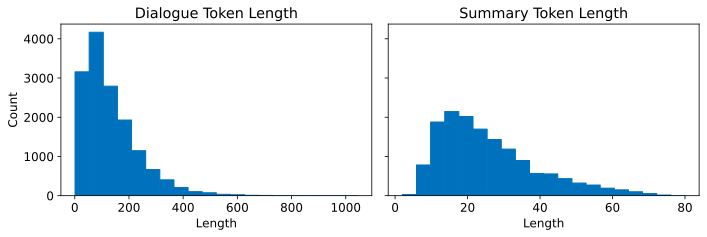

In [ ]:
d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [ ]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024,
                                truncation=True)
    
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=128,
                                     truncation=True)
    
    return {"input_ids": input_encodings["input_ids"],
            "attention_mask": input_encodings["attention_mask"],
            "labels": target_encodings["input_ids"]}

In [ ]:
dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, 
                                       batched=True)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [ ]:
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

In [ ]:
# 티처 포싱(teacher forcing)
# 텍스트 생성을 위한 디코더 입력과 레이블의 정렬
text = ['PAD','Transformers', 'are', 'awesome', 'for', 'text', 'summarization']
rows = []
for i in range(len(text)-1):
    rows.append({'step': i+1, 'decoder_input': text[:i+1], 'label': text[i+1]})
pd.DataFrame(rows).set_index('step')

,decoder_input,label
step,,
1,[PAD],Transformers
2,"[PAD, Transformers]",are
3,"[PAD, Transformers, are]",awesome
4,"[PAD, Transformers, are, awesome]",for
5,"[PAD, Transformers, are, awesome, for]",text
6,"[PAD, Transformers, are, awesome, for, text]",summarization


In [ ]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10, push_to_hub=True,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16)

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
trainer = Trainer(model=model, args=training_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"], 
                  eval_dataset=dataset_samsum_pt["validation"])

Cloning https://huggingface.co/fornoir/pegasus-samsum into local empty directory.


In [ ]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 3.2203, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.01}
{'loss': 3.0848, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.02}
{'loss': 3.1048, 'learning_rate': 3e-06, 'epoch': 0.03}
{'loss': 3.0867, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.04}
{'loss': 2.7972, 'learning_rate': 5e-06, 'epoch': 0.05}
{'loss': 2.8491, 'learning_rate': 6e-06, 'epoch': 0.07}
{'loss': 2.8246, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.08}
{'loss': 2.6051, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.09}
{'loss': 2.4961, 'learning_rate': 9e-06, 'epoch': 0.1}
{'loss': 2.2691, 'learning_rate': 1e-05, 'epoch': 0.11}
{'loss': 2.2506, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.12}
{'loss': 2.1764, 'learning_rate': 1.2e-05, 'epoch': 0.13}
{'loss': 2.2938, 'learning_rate': 1.3000000000000001e-05, 'epoch': 0.14}
{'loss': 2.1686, 'learning_rate': 1.4000000000000001e-05, 'epoch': 0.15}
{'loss': 2.0737, 'learning_rate': 1.5e-05, 'epoch': 0.16}
{'loss': 2.0694, 'learni

TrainOutput(global_step=920, training_loss=1.8293617352195408, metrics={'train_runtime': 2041.695, 'train_samples_per_second': 7.216, 'train_steps_per_second': 0.451, 'train_loss': 1.8293617352195408, 'epoch': 1.0})

In [ ]:
score = evaluate_summaries_pegasus(
    dataset_samsum["test"], rouge_metric, trainer.model, tokenizer,
    batch_size=2, column_text="dialogue", column_summary="summary")

100%|██████████| 410/410 [08:49<00:00,  1.29s/it]


In [ ]:
score

{'rouge1': AggregateScore(low=Score(precision=0.36801120891958955, recall=0.5618822236586024, fmeasure=0.41935473792158223), mid=Score(precision=0.37956653628676806, recall=0.5742185804036798, fmeasure=0.4290685836123722), high=Score(precision=0.3908256201132397, recall=0.5877847627536572, fmeasure=0.43806362845112234)),
 'rouge2': AggregateScore(low=Score(precision=0.16628138461007433, recall=0.26108675281154997, fmeasure=0.1899870181152253), mid=Score(precision=0.1760286923419677, recall=0.27472967726059294, fmeasure=0.19983952641967329), high=Score(precision=0.18462419842461278, recall=0.2881284456263144, fmeasure=0.20895652368127945)),
 'rougeL': AggregateScore(low=Score(precision=0.2897274824850895, recall=0.4512485736028179, fmeasure=0.3321763019167128), mid=Score(precision=0.2987857768950388, recall=0.46348352292609174, fmeasure=0.3406541554478123), high=Score(precision=0.3082748021745119, recall=0.47685856429315926, fmeasure=0.34905055220158876)),
 'rougeLsum': AggregateScore(l

In [ ]:
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=[f"pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.429069,0.19984,0.340654,0.34082


In [ ]:
pd.DataFrame(rouge_dict, index=[f"pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.429069,0.19984,0.340654,0.34082


In [ ]:
trainer.push_to_hub("Training complete!")

Upload file pytorch_model.bin:   0%|          | 32.0k/2.13G [00:00<?, ?B/s]

Upload file training_args.bin: 100%|##########| 3.43k/3.43k [00:00<?, ?B/s]

Upload file runs/Mar20_08-25-06_cb88c1615c82/events.out.tfevents.1679300779.cb88c1615c82.3446.0: 100%|########…

Upload file spiece.model:   2%|1         | 32.0k/1.82M [00:00<?, ?B/s]

Upload file runs/Mar20_08-25-06_cb88c1615c82/1679300779.0475676/events.out.tfevents.1679300779.cb88c1615c82.34…

To https://huggingface.co/fornoir/pegasus-samsum
   f4fe887..2b8d6ce  main -> main

   f4fe887..2b8d6ce  main -> main

To https://huggingface.co/fornoir/pegasus-samsum
   2b8d6ce..fb0db19  main -> main

   2b8d6ce..fb0db19  main -> main



'https://huggingface.co/fornoir/pegasus-samsum/commit/2b8d6ce98c358ab0b94fc113cd26f8745d29ebb1'

## 대화 요약 생성하기

In [ ]:
import transformers
transformers.logging.set_verbosity_error()

In [ ]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]

In [ ]:
# `/peagsus-samsum` 앞을 자신의 허브 사용자 이름으로 바꾸세요.
pipe = pipeline("summarization", model="fornoir/pegasus-samsum")

In [ ]:
print("대화:")
print(sample_text)
print("\n참조 요약:")
print(reference)
print("\n모델 요약:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

대화:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

참조 요약:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact
Larry.

모델 요약:
Amanda can't find Betty's number. Larry called Betty last time they were at the
park together. Hannah wants Amanda to text Larry. Amanda will text Larry.


In [ ]:
custom_dialogue = """\
Thom: Hi guys, have you heard of transformers?
Lewis: Yes, I used them recently!
Leandro: Indeed, there is a great library by Hugging Face.
Thom: I know, I helped build it ;)
Lewis: Cool, maybe we should write a book about it. What do you think?
Leandro: Great idea, how hard can it be?!
Thom: I am in!
Lewis: Awesome, let's do it together!
"""
print(pipe(custom_dialogue, **gen_kwargs)[0]["summary_text"])

Thom, Lewis and Leandro are going to write a book about transformers. Thom
helped build a library by Hugging Face. They are going to do it together.
